# A simple geographic model

This notebook aims to build a Pyro model and inference algorithm to infer the county-to-count infection rates over time given the following data:
- county level observed invections and deaths each data
- a large number of posterior sample phylogenies (conditioned only on genetic sequences)
- county location of most genetic samples

In [1]:
import datetime
import math
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import Bio.Phylo
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel

from pyrophylo.io import read_nexus_trees
from pyrophylo.phylo import MarkovTree

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pyro.enable_validation()
print(torch.__version__)
print(pyro.__version__)

1.5.1
1.4.0+10c767f1


## Load data

### County demograpics for Massachusetts

In [2]:
df = pd.read_csv("data/ma_zip_county.csv")
df.head()

,zip,city,county,pop
0,2301,Brockton,Plymouth,62929
1,2148,Malden,Middlesex,61354
2,2155,Medford,Middlesex,59793
3,2360,Plymouth,Plymouth,59133
4,2169,Quincy,Norfolk,56584


In [3]:
county_populations = defaultdict(int)
for county, pop in zip(df["county"], df["pop"]):
    county_populations[county] += pop
county_populations = dict(county_populations)
print(county_populations)

{'Plymouth': 509471, 'Middlesex': 1608039, 'Norfolk': 690173, 'Suffolk': 786312, 'Essex': 781354, 'Bristol': 558905, 'Berkshire': 127328, 'Hampden': 468855, 'Worcester': 819950, 'Hampshire': 162548, 'Barnstable': 216362, 'Franklin': 70555, 'Nantucket': 11101, 'Dukes': 17305}


In [4]:
counties = sorted(county_populations)
county_index = {name: i for i, name in enumerate(counties)}
population = torch.tensor([float(county_populations[c]) for c in counties])

## County approximate distances

Let's very roughly approximate the transitions between counties as a function of the distance between their centroids. A much more accurate approach would be to directly use cell phone mobility data over time. Our first distance-based approach will at least have the correct data type.

In [5]:
df = pd.read_csv("data/2019_Gaz_counties_national.txt", sep="\t")
for col in df.columns:
    df[col.strip()] = df[col]
df.head()

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,INTPTLONG
0,AL,1001,161526,Autauga County,1539602137,25706961,594.444,9.926,32.532237,-86.646440,-86.646440
1,AL,1003,161527,Baldwin County,4117621645,1132980868,1589.823,437.446,30.659218,-87.746067,-87.746067
2,AL,1005,161528,Barbour County,2292160139,50523213,885.008,19.507,31.870253,-85.405104,-85.405104
3,AL,1007,161529,Bibb County,1612167476,9602089,622.461,3.707,33.015893,-87.127148,-87.127148
4,AL,1009,161530,Blount County,1670103866,15015467,644.831,5.798,33.977358,-86.566440,-86.566440


In [6]:
# Restrict to Massachusetts.
df = df[df["USPS"] == "MA"]
df.head()

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,INTPTLONG
1217,MA,25001,606927,Barnstable County,1021019039,2360316945,394.218,911.324,41.799014,-70.211880,-70.211880
1218,MA,25003,606928,Berkshire County,2400600620,50708156,926.877,19.579,42.371493,-73.217928,-73.217928
1219,MA,25005,606929,Bristol County,1432544616,357465834,553.109,138.018,41.748588,-71.088894,-71.088894
1220,MA,25007,606930,Dukes County,267300554,1004283854,103.205,387.756,41.380970,-70.701499,-70.701499
1221,MA,25009,606931,Essex County,1275609141,870172223,492.515,335.975,42.642708,-70.864909,-70.864909


In [7]:
df["name"] = [name.replace(" County", "") for name in df["NAME"]]

In [8]:
import geopy.distance

name_lat_lon = list(zip(df["name"], df["INTPTLAT"], df["INTPTLONG"]))
distances = {
    (c1, c2): geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).miles
    for c1, lat1, lon1 in name_lat_lon
    for c2, lat2, lon2 in name_lat_lon
}
distance_matrix = torch.tensor([[distances[i, j] for i in counties] for j in counties])
print(distance_matrix[:4, :4])

tensor([[  0.0000, 159.5089,  45.4424,  38.4166],
        [159.5089,   0.0000, 117.6348, 146.6921],
        [ 45.4424, 117.6348,   0.0000,  32.3543],
        [ 38.4166, 146.6921,  32.3543,   0.0000]])


### Incidence time series

TODO read deaths time series

In [9]:
df = pd.read_csv("data/County_8_11_2020.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Date,County,Count,Deaths
0,2020-04-17,Barnstable,582.0,NaN
1,2020-04-17,Berkshire,390.0,NaN
2,2020-04-17,Bristol,1693.0,NaN
3,2020-04-17,Dukes,14.0,NaN
4,2020-04-17,Essex,4668.0,NaN


In [10]:
start_date = df["Date"].min()
end_date = df["Date"].max()
print(start_date)
print(end_date)
num_days = (end_date - start_date).days
print(num_days)

2020-04-17 00:00:00
2020-08-11 00:00:00
116


Convert from cumulative to new cases.

In [11]:
cum_cases = torch.zeros(len(counties), 1 + num_days)
for county, date, count in zip(df["County"], df["Date"], df["Count"]):
    try:
        i = county_index[county]
    except KeyError:
        continue
    t = (date - start_date).days
    cum_cases[i, t] = count
cases = (cum_cases[:, 1:] - cum_cases[:, :-1]).clamp_(min=0)

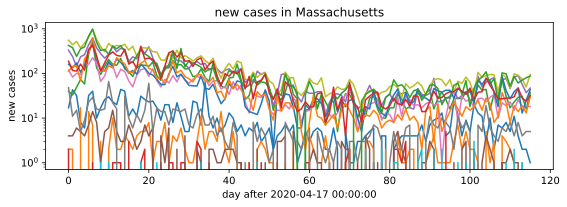

In [12]:
plt.figure(figsize=(8,3))
plt.plot(cases.T)
plt.yscale("log")
plt.ylabel("new cases")
plt.xlabel(f"day after {start_date}")
plt.title("new cases in Massachusetts")
plt.tight_layout()

### Genetic samples

In [13]:
df = pd.read_csv("data/sample_county.tsv", sep="\t")
df.head()

,sample_id,county
0,MA_MGH_00003,Middlesex
1,MA_MGH_00004,Middlesex
2,MA_MGH_00005,Norfolk
3,MA_MGH_00006,Suffolk
4,MA_MGH_00013,Middlesex


In [14]:
sample_id_to_county = {k: v for k, v in zip(df["sample_id"], df["county"])
                       if v in county_index}
print(len(sample_id_to_county))

696


### Phylogenetic trees

We load the tree floating point data as `trees` separately from metadata. To read metadata (for the same set of taxa among all sampled trees) we'll load a single example tree.

In [15]:
example_tree = next(read_nexus_trees("data/GTR4G_posterior.trees"))

In [16]:
leaves = sorted(example_tree.get_terminals(), key=lambda clade: clade.name)
schema = ["sample_id", "risk_group", "clade", "date"]
leaf_metadata = [dict(zip(schema, clade.comment.split("|"))) for clade in leaves]
for row in leaf_metadata:
    row["county"] = sample_id_to_county.get(row["sample_id"])
    row["county_id"] = county_index.get(row["county"], -1)
leaf_to_county = torch.tensor([row["county_id"] for row in leaf_metadata])
leaf_to_time = [(datetime.datetime.strptime(row["date"], "%Y-%m-%d") - start_date).days
                for row in leaf_metadata]

Now load all sample trees.

In [17]:
posterior_trees = torch.load("results/GTR4G_posterior.pt")
print(posterior_trees.batch_shape)
print(posterior_trees.num_leaves)

torch.Size([100001])
772


For now we will subsample a set of say 100 trees.

In [18]:
trees = posterior_trees[1000:]  # burn-in
trees = trees[::len(trees) // 100]  # stride
trees = trees[:100].contiguous()  # truncate
print(len(trees))

100


In [19]:
num_lineages = trees.num_lineages()

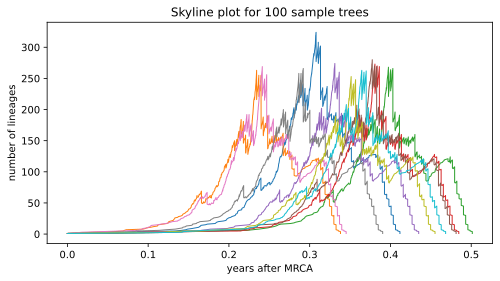

In [20]:
plt.figure(figsize=(8,4))
plt.plot(trees.times[:10].T, num_lineages[:10].T, lw=1)
plt.ylabel("number of lineages")
plt.xlabel("years after MRCA")
plt.title(f"Skyline plot for {len(trees)} sample trees");

Note these are timed from the root in units of 366days (about one year).

In [21]:
torch_times = trees.times[0][trees.leaves[0]]
(max(leaf_to_time) - min(leaf_to_time)) / (torch_times.max() - torch_times.min())

tensor(366.0000)

We affine transform to match the incidence time series.

In [22]:
trees.times -= trees.times.max(-1, keepdim=True).values
trees.times *= 366  # convert from ~years to days
trees.times += max(leaf_to_time)

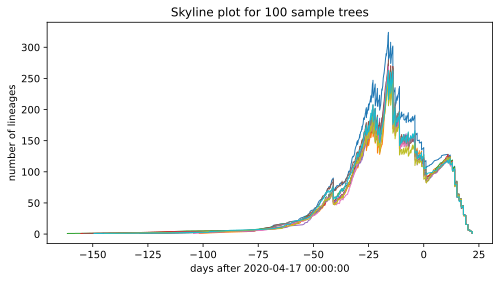

In [23]:
plt.figure(figsize=(8,4))
plt.plot(trees.times[:10].T, num_lineages[:10].T, lw=1)
plt.ylabel("number of lineages")
plt.xlabel(f"days after {start_date}")
plt.title(f"Skyline plot for {len(trees)} sample trees");

Note that most samples were collected before our cumulative incidence data starts.

## An epidemiological model

Let's try to use Pyro's [CompartmentalModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel) class, following the [tutorial](https://pyro.ai/examples/epi_intro.html#Regional-models) on regional epidemiological models.

In [24]:
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

class CountyModel(CompartmentalModel):
    # Let's explicitly input all data needed for inference;
    # that way the model can be saved and loaded for later prediction.
    def __init__(self, county_names, population, distance_matrix,
                 init_cases, new_cases, trees, leaf_to_county):
        N = len(county_names)
        T = len(new_cases)
        assert population.shape == (N,)
        assert distance_matrix.shape == (N, N)
        assert init_cases.shape == (N,)
        assert new_cases.shape == (T, N)
        assert leaf_to_county.shape == (trees.num_leaves,)
        compartments = ("S", "E", "I")  # R is implicit.
        duration = new_cases.size(-1)
        super().__init__(compartments, duration, population)
        self.county_names = county_names
        self.population = population  # assume this is constant over relevant timescale
        self.distance_matrix = distance_matrix
        self.init_cases = init_cases
        self.new_cases = new_cases
        self.trees = trees
        self.leaf_to_county = leaf_to_county

    def global_model(self):
        tau_e = 5.5  # incubation time
        tau_i = 14.  # recovery time
        # Assume basic reproductive number around 2.
        R0 = pyro.sample("R0", dist.LogNormal(math.log(2), 1.))
        # Assume about 40% response rate.
        rho = pyro.sample("rho", dist.Beta(4, 6))

        # Let's use a Gaussian kernel with learnable radius.
        radius = self.distance_matrix.mean()
        radius = pyro.sample("radius", dist.LogNormal(math.log(radius), 1.))
        coupling = self.distance_matrix.div(radius).pow(2).mul(-0.5).exp()
        
        return R0, tau_e, tau_i, rho, coupling

    def initialize(self, params):
        with self.region_plate:
            # Assume a small portion of cumulative cases are still infected.
            E = pyro.sample("E_init", binomial_dist(self.init_cases, 0.1))
            I = pyro.sample("I_init", binomial_dist(self.init_cases, 0.2))
            S = self.population - E - I
        return {"S": S, "E": E, "I": I}

    def transition(self, params, state, t):
        R0, tau_e, tau_i, rho, coupling = params
        I_coupled = state["I"] @ coupling
        I_coupled = I_coupled.clamp(min=0)
        pop_coupled = self.population @ coupling
        
        with self.region_plate:
            # Sample flows between compartments.
            S2E = pyro.sample("S2E_{}".format(t),
                              infection_dist(individual_rate=R0 / tau_i,
                                             num_susceptible=state["S"],
                                             num_infectious=I_coupled,
                                             population=pop_coupled))
            E2I = pyro.sample("E2I_{}".format(t),
                              binomial_dist(state["E"], 1 / tau_e))
            I2R = pyro.sample("I2R_{}".format(t),
                              binomial_dist(state["I"], 1 / tau_i))

            # Update compartments with flows.
            state["S"] = state["S"] - S2E
            state["E"] = state["E"] + S2E - E2I
            state["I"] = state["I"] + E2I - I2R

            # Condition on aggregate observations.
            t_is_observed = isinstance(t, slice) or t < self.duration
            pyro.sample("obs_{}".format(t),
                        binomial_dist(S2E, rho),
                        obs=self.new_cases[t] if t_is_observed else None)
            
            # Tree likelihood.
            provenance = coupling  # TODO adjust for population of source and destin
            pyro.sample("geolocation", MarkovTree(self.trees, provenance),
                        obs=self.leaf_to_county)

model = CountyModel(counties, population, distance_matrix,
                    cum_cases[:, 0], cases.T, trees, leaf_to_county)

In [25]:
if False:
    losses = model.fit_svi(guide_rank=0, num_samples=10, log_every=10)